In [1358]:
# !apt-get install build-essential python3-dev
# !apt-get install cmake
# !pip install XFoil
# !pip install torch torchvision

In [1359]:
# code for generating airfoil designs using online airfoil datasets
# code is inspired by:
# The Department of Energy [https://catalog.data.gov/dataset/airfoil-computational-fluid-dynamics-2k-shapes-25-aoas-3-re-numbers]



# specify which platform we are running on 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import math
import time
import copy
import sklearn
import platform
import subprocess



# for the GAN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split


# importing xfoil itself
# from xfoil import XFoil
# from xfoil.model import Airfoil



# state variables
MAC_PLATFORM = 1
LINUX_PLATFORM = 2
UNKNOWN_PLATFORM = 3
PLATFORM = UNKNOWN_PLATFORM

In [1360]:
# get the platform
os_type = platform.system()
if os_type == "Darwin":
	PLATFORM = MAC_PLATFORM
elif os_type == "Linux":
	PLATFORM = LINUX_PLATFORM
else:
	PLATFORM = UNKNOWN_PLATFORM

# should we be verbose
VERBOSE = True

# getting the file that we are currently working in 
# CURR_FILE_DIR = os.path.dirname(os.path.realpath(__file__))
CURR_FILE_DIR = "."

# define the directory that we are working in for the example files
EXAMPLE_DIR = "Example Data"

# the path to the data with the polar data
POLAR_FILE_NAME = "polar.txt"

# setting the path of the airfoil
full_data_path = os.path.join(CURR_FILE_DIR, "airfoil_2k_data.h5")

# path to the example data
example_data_path = os.path.join(CURR_FILE_DIR, EXAMPLE_DIR, "b737a.dat")

# defining the data files that we are gonna use
output_file = "polar.dat"
example_data_output = os.path.join(CURR_FILE_DIR, EXAMPLE_DIR, output_file)
dump_file = "dump.dat"
example_data_dump = os.path.join(CURR_FILE_DIR, EXAMPLE_DIR, dump_file)


# the number of data points that describe each of the point clouds
NUM_POINTS_POINT_CLOUD = 100

# number of random points that we pass to the generator network
RANDOM_INPUT_NUM = 512

# the upper and lower limits for the coefficients (abs val)
COEFF_UPPER = 2

# the amount of data that we are going to use for training
TRAINING_RATIO = 0.9


# the number of epochs to skip between discriminator evaluations
SKIP_EVAL_EPOCHS = 30

BATCH_SIZE = 64


# get the device that we can train on
device = torch.device("cpu")

# make the device cuda if it is available
if torch.cuda.is_available():
	device = torch.device("cuda")


# define the xfoil command depending on the platform
## CHANGE THIS IF NEEDED
if PLATFORM == MAC_PLATFORM:
	home_directory = os.path.expanduser("~")
	XFOIL_COMMAND = f"{home_directory}/Desktop/Xfoil-for-Mac/bin/xfoil"

	# change the device to leverage mps
	# this code taken directly from pytorch docs (https://pytorch.org/docs/stable/notes/mps.html)
	if not torch.backends.mps.is_available():
		if not torch.backends.mps.is_built():
			print("MPS not available because the current PyTorch install was not "
				"built with MPS enabled.")
		else:
			print("MPS not available because the current MacOS version is not 12.3+ "
				"and/or you do not have an MPS-enabled device on this machine.")

	else:
		device = torch.device("mps")

elif PLATFORM == LINUX_PLATFORM:
	XFOIL_COMMAND = "xfoil"

else:
	raise NotImplementedError("Running program on unsupported platform.")





In [1361]:
# getting the points from a file path
# this takes the path to a file that has airfoil points in it as the input to the function
def get_points_from_dat_file(file_path):

	with open(file_path, 'r') as file:
		lines = file.readlines()

	# filter out non-numeric lines and strip whitespace
	points = []
	for line in lines:

		# segment the line
		parts = line.strip().split()

		# split the line and iterate through the parts
		if len(parts) == 2:
			try:
				points.append((float(parts[0]), float(parts[1])))
			except ValueError:
				print(f"Skipping invalid line: {line}")
				pass

	return points


# pull data tensor and information
# from a single folder that has all of the data inside of it
def get_folder_data(folder_path = None, file_name = None):

    # pull the data tensor
    points = get_points_from_dat_file(os.path.join(folder_path, file_name + "_reformatted.dat"))

    # get the tensor
    points = np.array(points)

    # get the other parameters that we want
    resulting_data = pd.read_csv(os.path.join(folder_path, POLAR_FILE_NAME), delim_whitespace=True, skiprows=10)
    resulting_data = resulting_data.drop(0)

    # print(resulting_data)

    # pulling individual values
    alpha = float(resulting_data["alpha"].loc[1].replace("*", ''))   
    CL = float(resulting_data['CL'].loc[1].replace("*", ''))            
    CD = float(resulting_data['CD'].loc[1].replace("*", ''))           
    CDp = float(resulting_data['CDp'].loc[1].replace("*", ''))            
    CM = float(resulting_data['CM'].loc[1].replace("*", ''))     

    # print(f"alpha: {alpha}")
    # print(f"CL: {CL}")
    # print(f"CD: {CD}")
    # print(f"CDp: {CDp}")
    # print(f"CM: {CM}")

    # create labels tensor
    labels = np.array([CL, CDp, CM])

    # if any of the values are out of range then kill this example
    if any(np.abs(labels) > COEFF_UPPER):
        # print(labels)
        raise ValueError("Coefficient Bounds Violated")
	
    if(np.abs(np.array(points)) > 1).any():
        print("POINTS")

    # returning the generated values
    return (points, labels)


# define a function to create the tensors that we need
def pull_airfoil_data(wd=EXAMPLE_DIR):

    # the lists we will return
    ret_data_tensor = []
    ret_labels_tensor = []

    # iterate through all of the potential airfoils
    for airfoil_dat in os.listdir(wd):

        # print the airfoil type
        data_path = os.path.join(EXAMPLE_DIR, airfoil_dat)

        try:
            # pull the data
            t_data, t_labels = get_folder_data(folder_path=data_path, file_name=airfoil_dat)

        except Exception as e:
            if VERBOSE:
                print(f"{data_path} : {e}")
                
            continue

        # add the data to the list
        ret_data_tensor.append(t_data)
        ret_labels_tensor.append(t_labels)

    # print(ret_data_tensor)
    # print(ret_labels_tensor)

    # getting the shapes of the data
    # if VERBOSE

    # convert it to a numpy array
    ret_data_tensor = np.array(ret_data_tensor)
    ret_labels_tensor = np.array(ret_labels_tensor)

    print(f"\n\nret_data_tensor_shapes shapes: {ret_data_tensor.shape}")
    print(f"ret_labels_tensor_shapes shapes: {ret_labels_tensor.shape}")

    # change the final versions to tensors
    ret_data_tensor = torch.Tensor(ret_data_tensor)
    ret_labels_tensor = torch.Tensor(ret_labels_tensor)

    return ret_data_tensor, ret_labels_tensor




# the data sets are going to be formed of:
# 100-dimensional vector representing the input airfoil

# 3-dimensional vector representing the label coefficient, drag-pressure coefficient, and moment coefficient
airfoil_data, label_values = pull_airfoil_data(wd=EXAMPLE_DIR)

Example Data/hq17 : could not convert string to float: '0.000003096.28417'
Example Data/hs1404 : Coefficient Bounds Violated
Example Data/hs1606 : Coefficient Bounds Violated
Example Data/hs1620 : Coefficient Bounds Violated
Example Data/hs1708 : could not convert string to float: '0.000006371.02669'
Example Data/hs1712 : Coefficient Bounds Violated
Example Data/l1003 : Coefficient Bounds Violated
Example Data/lrn1015 : could not convert string to float: '2.000-162.6999'
Example Data/s102b : Coefficient Bounds Violated
Example Data/s102s : Coefficient Bounds Violated
Example Data/a18 : Coefficient Bounds Violated
Example Data/ah63k127 : Coefficient Bounds Violated
Example Data/ah80129 : Coefficient Bounds Violated
Example Data/ah83150q : Coefficient Bounds Violated
Example Data/ah93k132 : Coefficient Bounds Violated
Example Data/b707d : Coefficient Bounds Violated
Example Data/b737a : Coefficient Bounds Violated
Example Data/b737b : could not convert string to float: '0.000001740.48963

In [1362]:

# get the shapes to store them
airfoil_data_shape = airfoil_data.shape
label_values_shape = label_values.shape

# change the shape of the airfoil data
airfoil_data_copy = copy.copy(airfoil_data)
airfoil_data = airfoil_data_copy.view(-1, NUM_POINTS_POINT_CLOUD * 2)

print(f"RANDOM_INPUT_NUM: {RANDOM_INPUT_NUM}")

# creating the datasets
total_dataset = TensorDataset(torch.tensor(airfoil_data, dtype=torch.float32), torch.tensor(label_values, dtype=torch.float32))

train_dataset, test_dataset = random_split(total_dataset, [TRAINING_RATIO, 1 - TRAINING_RATIO])

# the train and the test for the data loader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"train_dataloader: {len(train_dataloader) * len(next(iter(train_dataloader))[0])}")
print(f"test_dataloader: {len(test_dataloader) * len(next(iter(test_dataloader))[0])}")

print()

print(f"dataloader: {next(iter(train_dataloader))[0].shape}")
print(f"dataloader: {next(iter(train_dataloader))[1].shape}")
print(f"dataloader: {next(iter(test_dataloader))[0].shape}")
print(f"dataloader: {next(iter(test_dataloader))[1].shape}")

RANDOM_INPUT_NUM: 512
train_dataloader: 1216
test_dataloader: 160

dataloader: torch.Size([32, 200])
dataloader: torch.Size([32, 3])
dataloader: torch.Size([32, 200])
dataloader: torch.Size([32, 3])


/var/folders/d2/lsvbp7p92gnc5ql59sc72rx40000gn/T/ipykernel_92834/1680941826.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_dataset = TensorDataset(torch.tensor(airfoil_data, dtype=torch.float32), torch.tensor(label_values, dtype=torch.float32))


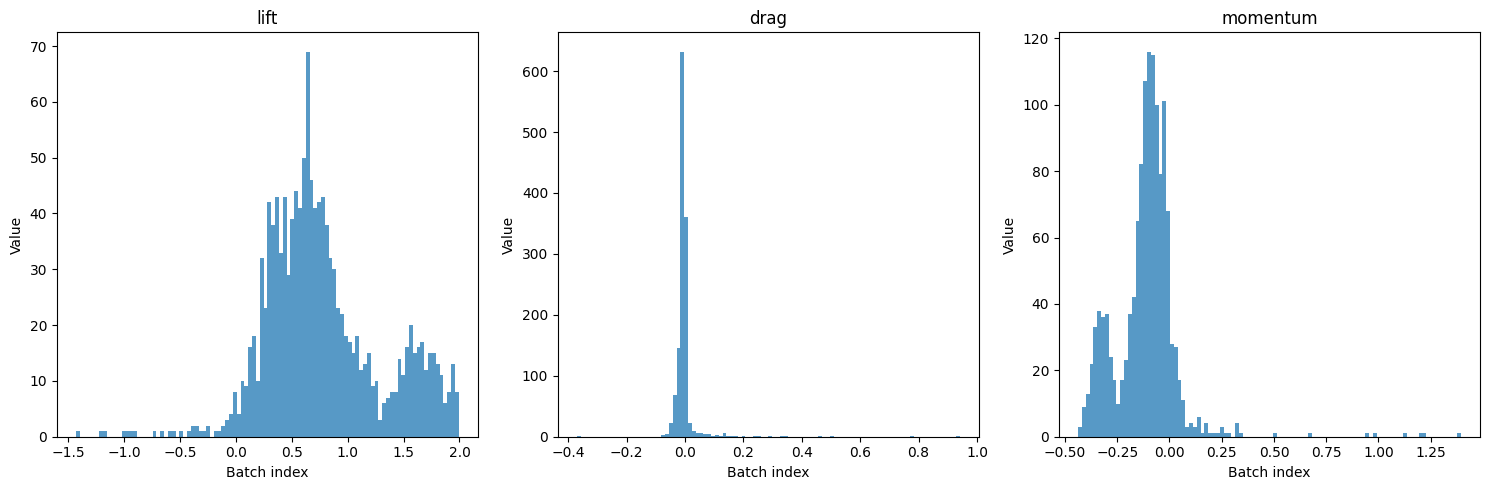

In [1363]:
# plot the labels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

titles = ['lift', 'drag', 'momentum']

# Plotting each element across the batch
for i in range(3):
    axes[i].hist(label_values[:, i], bins = 100, alpha=0.75, )  # Plot element i across all batches
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Batch index')
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [1364]:
# now go ahead and define the gan that we are going to be training
class Generator(nn.Module):
    
    def __init__(self, dropout_p=0.2):
        
        super(Generator, self).__init__()
        
        # define the sequential neural network
        self.fc = nn.Sequential(
            nn.Linear(RANDOM_INPUT_NUM + 3, 256),
            # nn.BatchNorm1d(256),
            # nn.LeakyReLU(True),


            nn.Dropout(dropout_p),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),
            nn.Linear(256, NUM_POINTS_POINT_CLOUD * 2),
            # nn.Tanh()
            # nn.LeakyReLU(0.2),
            # nn.Dropout(dropout_p),
            # nn.Linear(101, 256),  
        )

    # define the forward pass of the sequential neural network
    def forward(self, noise, c_label):

        if c_label.dim() == 1:
            c_label = c_label.unsqueeze(1)

        # concatenate the tensor of variables we want the airfoil to have and the noise
        input_tensor = torch.cat((noise, c_label), dim=1)
        return self.fc(input_tensor.to(device))


# this is the discriminator that is used to assess whether the 
# generator design has the correct lift value
class Discriminator(nn.Module):
    def __init__(self):

        super(Discriminator, self).__init__()

        # defining the sequential discriminator
        self.fc = nn.Sequential(
            nn.Linear(NUM_POINTS_POINT_CLOUD * 2, 64),  # 100 coordinates with 3 computed or real labels and 3 input values
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            # nn.LeakyReLU(0.2),
            # nn.Dropout(0.3),
            # nn.Linear(256, 1),
            nn.Sigmoid()
        )

    # defining the forward pass for the discriminator
    def forward(self, points):

        # putting the tensor of targets together
        # input_tensor = torch.cat((points, labels, target), dim=1)
        return self.fc(points.to(device))
    

# function for initializing the weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)




# create the models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# initialize the weights 
generator.apply(weights_init)
discriminator.apply(weights_init)

# create optimizers for the generator and discriminator
# optimizer_G = optim.Adam(generator.parameters(), lr=0.002, betas=(0.5, 0.999))
# optimizer_D = optim.Adam(discriminator.parameters(), lr=0.000002, betas=(0.5, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.002)











# this is the validator that is going to decide what the likely value for a certain coefficient is
class Coeff_Validator(nn.Module):
    def __init__(self):

        super(Coeff_Validator, self).__init__()

        # defining the sequential discriminator
        self.fc = nn.Sequential(
            nn.Linear(NUM_POINTS_POINT_CLOUD * 2, 64),  # 100 coordinates
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            # nn.LeakyReLU(0.2),
            # nn.Dropout(0.3),
            # nn.Linear(256, 1),
            # nn.Sigmoid()
        )

    # defining the forward pass for the discriminator
    def forward(self, points):

        # putting the tensor of targets together
        return self.fc(points.to(device))



# this is a function that initializes and creates the validator objects that we are going to use
# in order to train the GAN. These weights will not change
def initialize_validators():

    # initialize the number of discriminators that we need for the number of labels that we pull
    validator_dict = {
        'lift': Coeff_Validator().to(device),
        'drag': Coeff_Validator().to(device),
        'momentum': Coeff_Validator().to(device)
    }

    optimizer_dict = {
        'lift': None,
        'drag': None,
        'momentum': None
    }

    for disc_name, disc_object in validator_dict.items():
        
        # initialize a discriminator
        validator_dict[disc_name] = validator_dict[disc_name].apply(weights_init)

        # create the optimizer
        optimizer_dict[disc_name] = optim.Adam(validator_dict[disc_name].parameters(), lr=0.0002, betas=(0.5, 0.999))

    return validator_dict, optimizer_dict




# function to create noise
def generate_noise(size):
    return torch.randn(size, RANDOM_INPUT_NUM).to(device)



# define a class for early stopping
class EarlyStopping:
    
    # initialize the class
    def __init__(self, patience=7, min_delta=0, saving_path="best_model.ckpt"):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.b_loss = None
        self.early_stop = False
        self.saving_path = saving_path

    def __call__(self, v_loss, e_model):
        
        # update the early stopping params
        if self.b_loss is None:
            self.b_loss = v_loss

        # check if we should update
        elif v_loss > self.b_loss - self.min_delta:
            self.counter += 1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        
        else:
            self.save_checkpoint(v_loss, e_model)
            self.b_loss = v_loss
            self.counter = 0

    # save the model checkpoint
    def save_checkpoint(self, val_loss, model):
        print(f'Lower Validation Loss ({self.b_loss:.6f} --> {val_loss:.6f})')
        torch.save(model.state_dict(), self.saving_path)

    def load_checkpoint(self, model):
        model.load_state_dict(torch.load(self.saving_path))


# define a function that is going to pre-train the validators
# these are going to be used in place of CFD for inside of the training function for the sake of time 
# they will output the coefficient value that they think is right for some input point cloud
def train_validators(epochs, data_loader, test_loader, validator_dict, optimizer_dict):

    # create the loss function
    loss_function = nn.MSELoss()
    
    # keeping track of the total loss
    loss_dict = {}

    # iterate through the discriminators to update the parameters
    for disc_name, disc_object in validator_dict.items():

        # initalize an early stopping value for this validator
        early_stop = EarlyStopping(patience=10, min_delta=0.01)

        print(f"\n\nTraining {disc_name}")

        # go for each of the epochs
        for epoch in range(epochs):

            # initialize zero for the discriminators
            loss_dict[disc_name] = 0
            disc_loss = 0
            
            # load the information
            for real_shapes, labels in data_loader:

                # move the labels to the device
                labels = labels.to(device)

                # reset the optimizer
                optimizer = optimizer_dict[disc_name]
                optimizer.zero_grad()

                # get the predictions
                predictions = disc_object(real_shapes).to(device)
                
                # backpropagate the loss
                loss = loss_function(predictions.to(device), labels.to(device))
                loss.backward()
                optimizer.step()
                
                # add the loss
                disc_loss += loss

            # print the epoch ever so often
            if epoch % 5 == 0:
                print(f'Epoch {epoch}/{epochs} | Loss: {(disc_loss / len(data_loader)):.4f}')
                

            # compute the validation loss
            disc_object.eval()
            test_loss = 0

            with torch.no_grad():

                # go through the test loader and compute the loss
                for data, labels in test_loader:

                    # update the loss value
                    labels = labels.to(device)
                    predictions = disc_object(data).to(device)
                    test_loss += loss_function(predictions, labels)

            # normalize the test loss
            test_loss /= len(test_loader)
            loss_dict[disc_name] = test_loss

            # check for early stopping
            early_stop(test_loss, disc_object)

            # check for early stopping
            if early_stop.early_stop:
               
                print("Early stopping")

                # print the epoch
                print(f'\nEpoch {epoch}/{epochs} | Loss: {(early_stop.b_loss):.4f}')

                early_stop.load_checkpoint(validator_dict[disc_name])
                break
            
    print(f"\nDONE TRAINING\n")       
    for key, loss_val in loss_dict.items():
        print(f'Training Loss {key}: {(loss_val / len(data_loader)):.4f}')

    # return the validator and optimizer dictionaries
    return validator_dict, optimizer_dict


# now create the validators
validator_dict, optimizer_dict = initialize_validators()

# now train the validators
validator_dict, optimizer_dict = train_validators(100, train_dataloader, test_dataloader, validator_dict, optimizer_dict)


# make it so that the weights don't change anymore
for mod_name, mod_obj in validator_dict.items():

    # turn off the parameters
    for param in mod_obj.parameters():

        # turn off the gradient
        param.requires_grad = False



# training loop
def train_GAN(epochs, batch_size, train_dataloader, test_dataloader):

    # get the starting time
    curr_start = time.time()

    # create the loss function
    validator_loss_function = nn.MSELoss()
    discriminator_loss_function = nn.BCELoss()

    # initalize an early stopping value for this validator
    # early_stop = EarlyStopping(patience=70, min_delta=0.01, saving_path="best_discriminator.ckpt")

    # do it for some amount of epochs
    for epoch in range(epochs):

        if epoch % SKIP_EVAL_EPOCHS == 0:

            # go through the data in the data loader
            for i, (data, labels) in enumerate(train_dataloader):

                # reset the labels
                labels = torch.tensor(labels).to(device)

                # set the gradients to zero
                optimizer_G.zero_grad()
                optimizer_D.zero_grad()

                # generating random noise
                random_noise = generate_noise(len(labels)).to(device)

                # get the model output
                generator_output = generator(random_noise, labels)

                # add the losses together
                output_lift = validator_dict['lift'](generator_output)
                output_drag = validator_dict['drag'](generator_output)
                output_momentum = validator_dict['momentum'](generator_output)

                # print(f"output_lift: {output_lift}")
                # print(f"output_drag: {output_drag}")
                # print(f"output_momentum: {output_momentum}")
                # print(f"labels: {labels}")
                # print(f"labels[:, 0]: {labels[:, 0].view(-1, 1)}")

                # compute the losses
                loss_lift = validator_loss_function(output_lift, labels[:, 0].unsqueeze(1))
                loss_drag = validator_loss_function(output_drag, labels[:, 1].unsqueeze(1))
                loss_momentum = validator_loss_function(output_momentum, labels[:, 2].unsqueeze(1))

                # combine the loss functions together
                total_loss_model = loss_lift + loss_drag + loss_momentum

                # backwards propagate the loss
                total_loss_model.backward()

                # increment the optimizer
                optimizer_G.step()

                optimizer_G.zero_grad()
                optimizer_D.zero_grad()


            total_loss_model = total_loss_model / len(train_dataloader)

        else:

            total_loss_model = 0

        total_d_loss = 0
        total_g_loss = 0

        # now train the model with the GAN strategy
        for i, (data, labels) in enumerate(train_dataloader):

            # reset the labels
            labels = torch.tensor(labels).to(device)

            # set the gradients to zero
            optimizer_G.zero_grad()
            optimizer_D.zero_grad()

            real_labels = torch.ones(len(labels), 1).to(device)
            fake_labels = torch.zeros(len(labels), 1).to(device)

            # generating random noise
            random_noise = generate_noise(len(labels)).to(device)

            # get the model output
            fake_airfoils = generator(random_noise, labels)

            # get the discriminator output
            fake_output = discriminator(fake_airfoils)
            
            # now compare it with the real airfoils
            fake_loss = discriminator_loss_function(fake_output, fake_labels)



            # get the real loss
            real_output = discriminator(data)

            # real loss check now
            real_loss = discriminator_loss_function(real_output, real_labels)

            # compute the gradients
            d_loss = 0.5 * real_loss + 0.5 * fake_loss
            
            # step the loss function
            d_loss.backward(retain_graph=True)
            total_d_loss += d_loss
            
            # step the optimization function by one
            optimizer_D.step()

            
            # step the loss function
            # optimizer_G.zero_grad()
            random_noise = generate_noise(len(labels)).to(device)
            fake_airfoils = generator(random_noise, labels)
            g_loss = discriminator_loss_function(discriminator(fake_airfoils), real_labels)
            # print(f"g_loss: {g_loss}")
            # print(f'discriminator(fake_airfoils): {discriminator(fake_airfoils)}')
            # print(f'real_labels: {real_labels}\n\n')
            g_loss.backward()
            optimizer_G.step()
            total_g_loss += g_loss


        total_d_loss = total_d_loss / len(train_dataloader)        
        total_g_loss = total_g_loss / len(train_dataloader)        

        if epoch % SKIP_EVAL_EPOCHS == 0:
            print('(%d/%d) loss_lift: %.4f loss_drag: %.4f loss_momentum: %.4f ' % (epoch, epochs, loss_lift.item(), loss_drag.item(), loss_momentum.item()))
            print(f'{(time.time() - curr_start):.4f} seconds\t d_loss: {total_d_loss:.4f} g_loss: {total_g_loss:.4f}')
            curr_start = time.time()
            # print(f'({epoch}/{epochs}) d_loss: {total_d_loss:.4f} g_loss: {total_g_loss:.4f}')
            # print()

        # save the model every 1000 epochs or so
        if epoch % 1000 == 0:
            # get the model output
            random_noise = generate_noise(1)
            input_label = torch.tensor(np.array(label_values[0])).unsqueeze(0).to(device)
            input_noise = torch.tensor(random_noise).to(device)
            gen_points = generator(input_noise, input_label)
            print()
            print(f"Max: {max(gen_points[0])}")
            print(f"Min: {min(gen_points[0])}")
            # print(gen_points)
            print(discriminator(gen_points))
            print(discriminator(next(iter(train_dataloader))[0][0]))
            print()


            torch.save(generator.state_dict(), f"./model_checkpoints/generator_{epoch}.ckpt")
            torch.save(discriminator.state_dict(), f"./model_checkpoints/discriminator_{epoch}.ckpt")
            for disc_name, disc_object in validator_dict.items():
                torch.save(discriminator.state_dict(), f"./model_checkpoints/{disc_name}_{epoch}.ckpt")



        # check for early stopping
        # early_stop(total_d_loss + total_g_loss + total_loss_model, discriminator)
        # early_stop(total_d_loss + total_g_loss, discriminator)

        # # check for early stopping
        # if early_stop.early_stop:
            
        #     print("Early stopping")

        #     # print the epoch
        #     # print(f'\nEpoch {epoch}/{epochs} | Combined Loss: {(total_d_loss + total_g_loss + total_loss_model):.4f}')
        #     print(f'\nEpoch {epoch}/{epochs} | Combined Loss: {(total_d_loss + total_g_loss):.4f}')

        #     break

train_GAN(epochs=1000000, batch_size=256, train_dataloader=train_dataloader, test_dataloader=None)



Training lift


/Users/tristanbrigham/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 3])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/tristanbrigham/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 3])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/tristanbrigham/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 3])) that is different to the input size (torch.Size([3, 1])). This will likely lead 

Epoch 0/100 | Loss: 1.0325
Lower Validation Loss (0.246577 --> 0.219710)
Epoch 5/100 | Loss: 0.5081
Lower Validation Loss (0.219710 --> 0.203164)
Epoch 10/100 | Loss: 0.2587
Epoch 15/100 | Loss: 0.2569
Early stopping

Epoch 16/100 | Loss: 0.2032


Training drag
Epoch 0/100 | Loss: 0.3482
Lower Validation Loss (0.225372 --> 0.200980)
Epoch 5/100 | Loss: 0.2681
Epoch 10/100 | Loss: 0.2573
Early stopping

Epoch 14/100 | Loss: 0.2010


Training momentum
Epoch 0/100 | Loss: 0.3122
Lower Validation Loss (0.266667 --> 0.242734)
Lower Validation Loss (0.242734 --> 0.231294)
Lower Validation Loss (0.231294 --> 0.208709)
Epoch 5/100 | Loss: 0.2837
Epoch 10/100 | Loss: 0.2703
Early stopping

Epoch 14/100 | Loss: 0.2087

DONE TRAINING

Training Loss lift: 0.0052
Training Loss drag: 0.0052
Training Loss momentum: 0.0054


/var/folders/d2/lsvbp7p92gnc5ql59sc72rx40000gn/T/ipykernel_92834/2410918967.py:344: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
/var/folders/d2/lsvbp7p92gnc5ql59sc72rx40000gn/T/ipykernel_92834/2410918967.py:398: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


(0/1000000) loss_lift: 0.9447 loss_drag: 0.0101 loss_momentum: 0.0715 
1.5515 seconds	 d_loss: 0.5860 g_loss: 0.7573

Max: 0.29892244935035706
Min: -0.07379627227783203
tensor([[0.5843]], device='mps:0', grad_fn=<SigmoidBackward0>)
tensor([0.7702], device='mps:0', grad_fn=<SigmoidBackward0>)



/var/folders/d2/lsvbp7p92gnc5ql59sc72rx40000gn/T/ipykernel_92834/2410918967.py:466: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_noise = torch.tensor(random_noise).to(device)


In [ ]:
# generating random noise
random_noise = generate_noise(1)

input_label = torch.tensor(np.array(label_values[0])).unsqueeze(0)
input_noise = torch.tensor(random_noise)

print(f"random_noise: {input_label.shape}")
print(f"label_values: {input_noise.shape}")

# get the model output
gen_points = generator(input_noise, input_label)
print(f"Max: {max(gen_points[0])}")
print(f"Min: {min(gen_points[0])}")
# print(gen_points)
print(discriminator(gen_points))
print(discriminator(next(iter(train_dataloader))[0][0]))

random_noise: torch.Size([1, 3])
label_values: torch.Size([1, 512])
Max: 1.6422215700149536
Min: -0.7000489234924316
tensor([[0.4998]], grad_fn=<SigmoidBackward0>)
tensor([0.4938], grad_fn=<SigmoidBackward0>)


/var/folders/d2/lsvbp7p92gnc5ql59sc72rx40000gn/T/ipykernel_92834/784500742.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_noise = torch.tensor(random_noise)


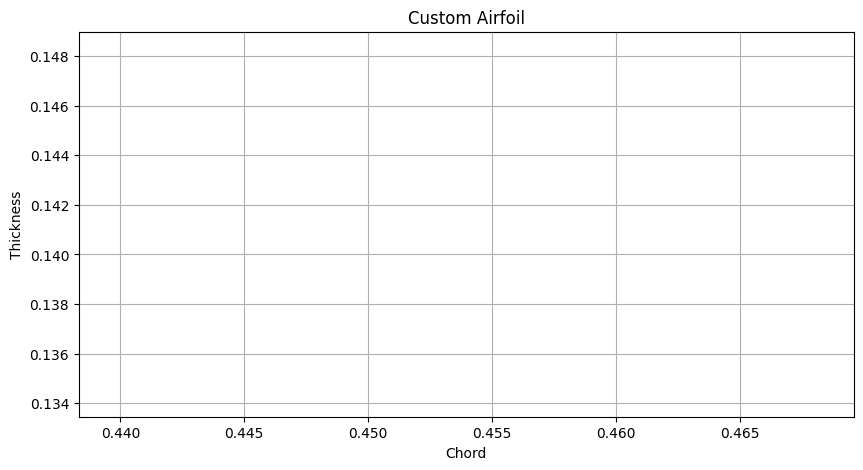

In [ ]:
# generate coordinates for a NACA 4210 airfoil.
def show_airfoil(point_array = None, file_path = None):

    # check that the arguments are valid
    if point_array is None and file_path is None:
        raise ValueError("Improper arguments passed to the file")

    # if the file path is where we should be pulling from then get it
    if file_path is not None:
        point_array = get_points_from_dat_file(file_path)

    # split the points properly given that we have tuples
    xu, yu, xl, yl = [], [], [], []
    for i, point in enumerate(point_array):
        if i < len(point_array) / 2:
            xu.append(point[0])
            yu.append(point[1])
        else:
            xl.append(point[0])
            yl.append(point[1])

    for i in range(len(xu) > len(xl)):
        xu.append(xu[-1])
        yu.append(yu[-1])

    for i in range(len(xu) - len(xl)):
        xu.append(xu[-1])
        yu.append(yu[-1])

    xu.reverse()
    
    xl.append(xu[-1])
    yl.append(yu[-1])
    xu.append(xl[-1])
    yu.append(yl[-1])

    # plot airfoil
    plt.figure(figsize=(10, 5))
    plt.plot(xu, yu, 'b', xl, yl, 'r')  # upper in blue, lower in red
    plt.fill_between(xu, yu, yl, color='gray', alpha=0.5)
    plt.axis('equal')
    plt.title("NACA 4210 Airfoil" if point_array is None else "Custom Airfoil")
    plt.xlabel("Chord")
    plt.ylabel("Thickness")
    plt.grid(True)
    plt.show()

show_airfoil(point_array=gen_points.detach().numpy())

In [ ]:
# generator = torch.load()
generator = Generator()
generator.load_state_dict(torch.load("./model_checkpoints/generator_1000.ckpt"))

# generating random noise
random_noise = generate_noise(1).to(device)

input_label = torch.tensor(np.array(label_values[0])).unsqueeze(0).to(device)
input_noise = torch.tensor(random_noise).to(device)

print(f"random_noise: {input_label.shape}")
print(f"label_values: {input_noise.shape}")

# get the model output
gen_points = generator(input_noise, input_label)
print(f"Max: {max(gen_points[0])}")
print(f"Min: {min(gen_points[0])}")
# print(gen_points)
print(discriminator(gen_points))
print(discriminator(next(iter(train_dataloader))[0][0]))

random_noise: torch.Size([1, 3])
label_values: torch.Size([1, 512])
Max: 1.0231503248214722
Min: -0.37524697184562683
tensor([[0.4997]], grad_fn=<SigmoidBackward0>)
tensor([0.4976], grad_fn=<SigmoidBackward0>)


/var/folders/d2/lsvbp7p92gnc5ql59sc72rx40000gn/T/ipykernel_92834/1183492783.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_noise = torch.tensor(random_noise)
